# Single-label image classification

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from plantclef.spark import get_spark

spark = get_spark(cores=4)
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/17 00:35:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/17 00:35:59 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


### embeddings

In [4]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Thu Apr 17 12:36:02 AM EDT 2025


### test embeddings

In [5]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/parquet"

# Define the path to the parquet files
test_path = f"{data_path}/test_2025"

# Read the parquet files into a spark DataFrame
test_df = spark.read.parquet(test_path)

# Show the data
test_df.printSchema()
test_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)



+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-Pla-B3-201907...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-E5-20180...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-B1-20140...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-Pla-D4-201507...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-F3-20190...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [5]:
import timm
import torch
from plantclef.model_setup import setup_fine_tuned_model


num_classes = 7806  # total number of plant species
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model(
    "vit_base_patch14_reg4_dinov2.lvd142m",
    pretrained=False,
    num_classes=num_classes,
    checkpoint_path=setup_fine_tuned_model(),
)
# Data transform
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)
# Move model to GPU if available
model.to(device)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [6]:
import pandas as pd


# load the cluster probabilities dataframes
def get_cluster_probability_dfs():
    clustering_path = "~/p-dsgt_clef2025-0/shared/plantclef/data/clustering"
    test_cluster_csv = f"{clustering_path}/test_2025_dominant_clusters.csv"
    test_cluster_probabilities = (
        f"{clustering_path}/test_2025_embed_probabilities_clustered"
    )
    cluster_df = pd.read_csv(test_cluster_csv)
    probabilities_df = pd.read_parquet(test_cluster_probabilities)
    return cluster_df, probabilities_df


def get_prior_for_image(image_name, cluster_df, probabilities_df) -> dict:
    row = cluster_df[cluster_df["image_name"] == image_name]
    cluster_id = row.iloc[0]["kmeans_cluster"]
    prior_row = probabilities_df[probabilities_df["dominant_cluster"] == cluster_id]
    return prior_row.iloc[0]["renormalized_probabilities"]


cluster_df, probabilities_df = get_cluster_probability_dfs()
display(cluster_df.head(5))
display(probabilities_df.head(5))

,image_name,kmeans_cluster
0,CBN-Pla-A1-20190814.jpg,2
1,CBN-Pla-D6-20190814.jpg,2
2,CBN-PdlC-C5-20140901.jpg,1
3,LISAH-BOU-0-37-20230512.jpg,0
4,CBN-Pla-E4-20130808.jpg,2


,dominant_cluster,renormalized_probabilities
0,1,"[2.3629971e-05, 4.4991793e-05, 4.332371e-05, 1..."
1,2,"[2.4171377e-05, 2.2901053e-05, 1.4540791e-05, ..."
2,0,"[5.1414485e-05, 0.00010827277, 0.00010225503, ..."


In [7]:
from plantclef.config import get_class_mappings_file

use_grid = True
use_prior = True


def load_class_mapping(class_mapping_file):
    with open(class_mapping_file) as f:
        class_index_to_class_name = {i: line.strip() for i, line in enumerate(f)}
    return class_index_to_class_name


def split_into_grid(image, grid_size=4):
    w, h = image.size
    grid_w, grid_h = w // grid_size, h // grid_size
    images = []
    for i in range(grid_size):
        for j in range(grid_size):
            left = i * grid_w
            upper = j * grid_h
            right = left + grid_w
            lower = upper + grid_h
            crop_image = image.crop((left, upper, right, lower))
            images.append(crop_image)
    return images


class_mapping_file = get_class_mappings_file()
cid_to_spid = load_class_mapping(class_mapping_file)

In [8]:
from plantclef.serde import deserialize_image

# select first image
image_name = test_df.select("image_name").first()[0]
image_data = test_df.select("data").first()[0]
image_data = deserialize_image(image_data)

print(f"image name: {image_name}")
print(f"image data: {type(image_data)}")
print(f"image data shape: {image_data.size}")

image name: CBN-Pla-B3-20190723.jpg
image data: <class 'PIL.JpegImagePlugin.JpegImageFile'>
image data shape: (3500, 3184)


In [9]:
def predict(
    image_data,
    cluster_df,
    probabilities_df,
    use_prior: bool = False,
    use_grid: bool = False,
    grid_size: int = 4,
    topk_proba: int = 10,
):
    images = [image_data]
    if use_grid:
        images = split_into_grid(image_data, grid_size=grid_size)

    results = []
    for img in images:
        with torch.no_grad():
            img = transforms(img).unsqueeze(0).to(device)
            outputs = model(img)  # unsqueeze single image into batch of 1
            probabilities = torch.softmax(outputs, dim=1)
            if use_prior:
                prior = get_prior_for_image(image_name, cluster_df, probabilities_df)
                probabilities = probabilities * torch.tensor(prior).to(device)
            top_probs, top_indices = torch.topk(probabilities, k=topk_proba)
        top_probs = top_probs.cpu().detach().numpy()[0]
        top_indices = top_indices.cpu().detach().numpy()[0]
        result = [
            {cid_to_spid[int(index)]: float(prob)}
            for index, prob in zip(top_indices, top_probs)
        ]
        results.append(result)
    # flatten the results from all grids, get top probabilities
    flattened_results = [item for grid in results for item in grid[:topk_proba]]
    # sort by score in descending order
    sorted_logits = sorted(flattened_results, key=lambda x: -list(x.values())[0])

    return sorted_logits

### without grid of tiles

In [10]:
# without grid
# original results
original_results = predict(image_data, cluster_df, probabilities_df, use_prior=False)
original_results

[{'1361281': 0.36755260825157166},
 {'1395807': 0.01984396018087864},
 {'1741880': 0.0167352557182312},
 {'1390690': 0.011740563437342644},
 {'1741903': 0.011048056185245514},
 {'1397565': 0.01017786841839552},
 {'1361275': 0.006565099116414785},
 {'1398779': 0.006193633656948805},
 {'1414270': 0.0060384804382920265},
 {'1396717': 0.006015494931489229}]

In [11]:
# prior results
prior_results = predict(image_data, cluster_df, probabilities_df, use_prior=True)
prior_results

[{'1361281': 0.028440652415156364},
 {'1395807': 0.0004967988352291286},
 {'1741880': 0.0002662691113073379},
 {'1397565': 8.511155465384945e-05},
 {'1396717': 5.7824050600174814e-05},
 {'1741903': 4.429689943208359e-05},
 {'1361275': 3.6528264899970964e-05},
 {'1743474': 3.6276418541092426e-05},
 {'1398779': 2.987371408380568e-05},
 {'1397070': 2.9231074222479947e-05}]

### with tiling

In [12]:
# original results
original_results = predict(
    image_data,
    cluster_df,
    probabilities_df,
    use_prior=False,
    use_grid=True,
    topk_proba=10,
)
display(len(original_results))
original_results[:10]

160

[{'1743656': 0.1817832589149475},
 {'1395807': 0.140432670712471},
 {'1361281': 0.12187014520168304},
 {'1394311': 0.11604467779397964},
 {'1389929': 0.0990738645195961},
 {'1361281': 0.0827433317899704},
 {'1743656': 0.0775211900472641},
 {'1395807': 0.07606909424066544},
 {'1388766': 0.0726073756814003},
 {'1395807': 0.07253968715667725}]

In [13]:
# original results
prior_results = predict(
    image_data,
    cluster_df,
    probabilities_df,
    use_prior=True,
    use_grid=True,
)
display(len(prior_results))
prior_results[:10]

160

[{'1361281': 0.00943012349307537},
 {'1361281': 0.006402550730854273},
 {'1361281': 0.004410626832395792},
 {'1361281': 0.004285097122192383},
 {'1395807': 0.003515769261866808},
 {'1361281': 0.002950152615085244},
 {'1361281': 0.00207728985697031},
 {'1361281': 0.002017206745222211},
 {'1395807': 0.0019044099608436227},
 {'1395807': 0.0018160503823310137}]

In [14]:
def extract_top_k_species(logits: list, topk: int = 10) -> list:
    """Extracts the top k species from the logits list."""
    top_logits = [list(item.keys())[0] for item in logits[:topk]]
    set_logits = sorted(set(top_logits), key=top_logits.index)
    return set_logits

In [15]:
original_top_k = extract_top_k_species(original_results, topk=10)
prior_top_k = extract_top_k_species(prior_results, topk=10)
print(f"Original top k species: {original_top_k}")
print(f"Prior top k species: {prior_top_k}")

Original top k species: ['1743656', '1395807', '1361281', '1394311', '1389929', '1388766']
Prior top k species: ['1361281', '1395807']


### use Hill Number

In [6]:
# path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/embeddings/test_2025"

# define the path to the train and test parquet files
test_path = f"{data_path}/test_2025_embed_logits"

# read the parquet files into a spark DataFrame
test_df = spark.read.parquet(test_path)

# show the data
test_df.printSchema()
test_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- output: struct (nullable = true)
 |    |-- cls_token: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- logits: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |-- sample_id: integer (nullable = true)

+--------------------+--------------------+---------+
|          image_name|              output|sample_id|
+--------------------+--------------------+---------+
|CBN-Pla-A1-201908...|{[0.47354543, 1.5...|        0|
|CBN-Pla-D6-201908...|{[-0.39621377, 1....|        0|
|CBN-PdlC-C5-20140...|{[-0.5331654, 0.2...|        0|
|LISAH-BOU-0-37-20...|{[1.2480925, 0.47...|        0|
|CBN-Pla-E4-201308...|{[0.7065191, 1.70...|        0|
+--------------------+--------------------+---------+
only showing top 5 rows



In [ ]:
import numpy as np
from pyspark.sql import functions as F


def hill_number_order1(probs):
    probs = np.array(probs)
    # filter out zero probabilities to avoid log(0)
    probs = probs[probs > 0]
    shannon_entropy = -np.sum(probs * np.log(probs))
    return np.exp(shannon_entropy)


@F.udf("float")
def hill_udf(arr):
    return float(hill_number_order1(arr))


@F.udf("array<float>")
def softmax_udf(arr):
    arr = np.array(arr)
    arr = np.exp(arr - np.max(arr))
    return (arr / arr.sum()).astype(float).tolist()


with_hill = (
    test_df.select("image_name", "output.logits")
    .withColumn("proba", softmax_udf("logits"))
    .withColumn("diversity", hill_udf("proba"))
)

with_hill.select("diversity").describe().show()

+-------+-----------------+
|summary|        diversity|
+-------+-----------------+
|  count|             2105|
|   mean|535.3989930746391|
| stddev|389.2140981330529|
|    min|        3.0576649|
|    max|        2940.2195|
+-------+-----------------+



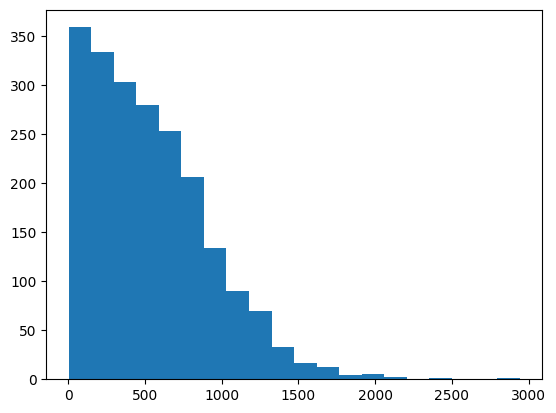

In [ ]:
from matplotlib import pyplot as plt

pdf = with_hill.select("diversity").toPandas()
plt.hist(pdf.diversity, bins=20)
plt.show()